In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats
import pandas as pd

import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [3]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7b_VK05')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df['fly_id'] = [row['date']+'_'+row['fly'] for _, row in sess_df.iterrows()]

In [4]:
sess_df = sess_df.loc[sess_df['drug']==0]

In [9]:
def get_ts(pp, coef = 0.3):
   
    y_epg = pp.timeseries['rois_z']
    heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
    bar_vis_mask = np.abs(heading)>1.5
    
    y_epg_sm = y_epg-1
    
    n_rois = y_epg.shape[1]
    
    x_f,y_f = st2p.utilities.pol2cart(y_epg_sm[0,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
    rho_epg, phi_epg = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

    
    _,offset_epg = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_epg-heading))
    
    return {'heading': heading,
            'bar_vis_mask': bar_vis_mask,
            'y_epg': y_epg,
            'y_epg_sm': y_epg_sm,
            'rho_epg': rho_epg,
            'phi_epg': phi_epg,
            'offset_epg': offset_epg}

def align_to_heading(ts):
    heading_bins = np.linspace(-np.pi, np.pi, num=17)
    heading_dig = np.digitize(ts['heading'], heading_bins)-1

    y_h_aligned = np.zeros_like(ts['y_epg_sm'][0,:,:])
    for ind in range(ts['heading'].shape[0]):
        y_h_aligned[:,ind] = np.roll(ts['y_epg_sm'][0,:,ind], -heading_dig[ind])
    
    return heading_bins, y_h_aligned

In [11]:
epg_avg = []
epg_avg_b = []

offset_var = []
for _, row in sess_df.iterrows():
    outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    ts = get_ts(pp)


    heading_bins, y_h_aligned_z = align_to_heading(ts)
    centers = (heading_bins[:-1] + heading_bins[1:])/2


    
    ha_avg_epg = y_h_aligned_z[:,:][:,ts['bar_vis_mask']].mean(axis=-1)
    
    ha_avg_epg_b = y_h_aligned_z[:,:][:,~ts['bar_vis_mask']].mean(axis=-1)
    
    


    argmax_epg = np.argmax(ha_avg_epg)
    
    epg_avg.append(np.roll(ha_avg_epg, -argmax_epg-8))
   
    argmax_epg_b = np.argmax(ha_avg_epg_b)
    epg_avg_b.append(np.roll(ha_avg_epg_b, -argmax_epg_b-8))
   
    
    offset_var.append(sp.stats.circvar(ts['offset_epg'][ts['bar_vis_mask']]))
   
epg_avg = np.array(epg_avg)

epg_avg_b = np.array(epg_avg_b)

offset_var = np.array(offset_var)


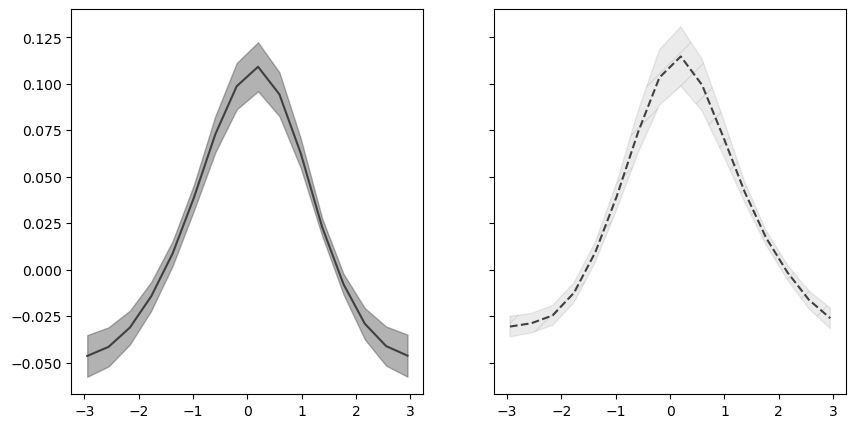

In [13]:
heading_bins = np.linspace(-np.pi, np.pi, num=17)
centers = (heading_bins[:-1] + heading_bins[1:])/2

fig, ax = plt.subplots(1,2,sharey=True, sharex=True, figsize=[10,5])
# offset_var_mask = offset_var<1

mu, sem = epg_avg.mean(axis=0), sp.stats.sem(epg_avg,axis=0)
ax[0].plot(centers, mu, color=plt.cm.Greys(.8))
ax[0].fill_between(centers, mu-sem, mu+sem, color=plt.cm.Greys(.8), alpha=.4)

mu, sem = epg_avg_b.mean(axis=0), sp.stats.sem(epg_avg_b,axis=0)
ax[1].plot(centers, mu, color=plt.cm.Greys(.8), linestyle= '--')
ax[1].fill_between(centers, mu-sem, mu+sem, color=plt.cm.Greys(.8), alpha=.1,hatch='/')